In [1]:
#import some necessary libraries
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p
from catboost import Pool, CatBoostRegressor

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
lam_l = 0.35
competition = 'SR'

from subprocess import check_output
#print(check_output(["ls", "-rlt", "../StackedRegression"]).decode("utf8")) #check the files available in the directory
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

StartTime = datetime.datetime.now()

In [2]:
train = pd.read_csv('HousePricesTrain.csv')
test = pd.read_csv('HousePricesTest.csv')
y_train = boxcox1p(train['SalePrice'], lam_l) 

train.drop("SalePrice", axis = 1, inplace = True)

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

alternate data source using top n features from Sequential Feature Selector (FeatureSelection.ipynb)

Reference: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

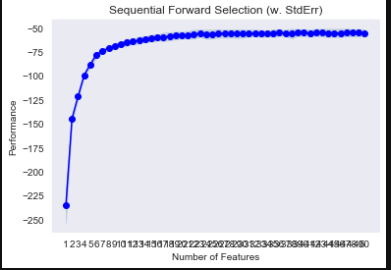

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mae(y, y_pred):
    return mean_absolute_error(y,y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:  5.8min finished

[2020-08-01 12:11:13] Features: 1/25 -- score: -235.74105066907396[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed: 12.8min finished

[2020-08-01 12:24:04] Features: 2/25 -- score: -144.87159640174195[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed: 13.3min finished

[2020-08-01 12:37:22] Features: 3/25 -- score: -121.54539375986181[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

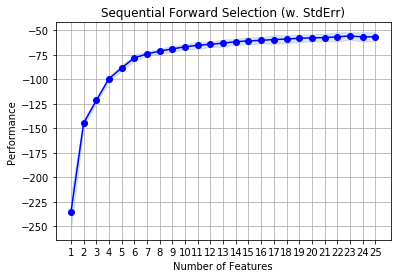

In [4]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# accuracy levels off at k_features=25, this code takes several hours to run!!
CBoost_new = CatBoostRegressor(logging_level='Silent', random_state=15, depth=5, l2_leaf_reg=1.0, n_estimators=1700,eval_metric='RMSE',learning_rate=0.025,random_strength=3.7,bagging_temperature=1.0,grow_policy='SymmetricTree',bootstrap_type='Bayesian')#,bayesian_matrix_reg=0.10000000149011612)
feature_select = 1
if (feature_select == 1):
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS

    sfs1 = SFS(CBoost_new, 
               k_features=25, 
               forward=True, 
               floating=False, 
               verbose=2,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(train, y_train)

    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    import matplotlib.pyplot as plt

    fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()

In [5]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs1.transform(train)
X_test_sfs = sfs1.transform(test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
CBoost_new.fit(X_train_sfs, y_train)
cb_pred = inv_boxcox1p(CBoost_new.predict(X_train_sfs), lam_l)

# Compute the accuracy of the prediction
#classification
#acc = float((y_train == y_pred).sum()) / y_pred.shape[0]
#print('Test set accuracy: %.2f %%' % (acc * 100))
#regression
print("mae",mae(y_train, cb_pred))
print("rmsle",rmsle(y_train, cb_pred))

mae 180340.3840334702
rmsle 196373.70899122496


In [6]:
#k_feature_names_
train_sfs = pd.DataFrame(X_train_sfs, index=train_ID, columns=sfs1.k_feature_names_)
test_sfs = pd.DataFrame(X_test_sfs, index=test_ID, columns=sfs1.k_feature_names_)

In [7]:
import pickle
from copy import deepcopy
# save data
with open('X_train_sfs_25.pkl', 'wb') as fid:
    pickle.dump(train_sfs, fid)   
with open('X_test_sfs_25.pkl', 'wb') as fid:
    pickle.dump(test_sfs, fid)
# load it again
with open('X_train_sfs_25.pkl', 'rb') as fid:
    X_train_sfs = pickle.load(fid)
with open('X_test_sfs_25.pkl', 'rb') as fid:
    X_test_sfs = pickle.load(fid)

In [8]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-08-01 12:05:26.325571
End:  2020-08-01 19:36:19.857516


In [9]:
X_train_sfs

,LotArea,LotShape,OverallQual,OverallCond,TotalBsmtSF,GrLivArea,KitchenAbvGr,Functional,Fireplaces,GarageCars,...,MSZoning_C (all),Neighborhood_Crawfor,Neighborhood_NridgHt,Condition1_Artery,Condition2_RRNn,Exterior1st_BrkFace,Exterior1st_ImStucc,Heating_Floor,GarageType_CarPort,SaleType_New
Id,,,,,,,,,,,,,,,,,,,,,
1,19.212,1.541,2.440,1.820,11.693,13.699,0.730,2.260,0.000,1.194,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,19.712,1.541,2.260,2.440,12.792,12.792,0.730,2.260,0.730,1.194,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,20.347,0.000,2.440,1.820,11.892,13.832,0.730,2.260,0.730,1.194,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,19.692,0.000,2.440,1.820,11.354,13.711,0.730,2.260,0.730,1.541,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,21.325,0.000,2.603,1.820,12.511,14.480,0.730,2.260,0.730,1.541,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,18.961,1.541,2.260,1.820,11.990,13.585,0.730,2.260,0.730,1.194,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1457,20.995,1.541,2.260,2.056,13.386,14.295,0.730,1.194,1.194,1.194,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1458,19.476,1.541,2.440,2.603,12.528,14.679,0.730,2.260,1.194,0.730,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [10]:
sfs1.k_score_

-56.56995060262938